In [ ]:
import os
import zipfile
file_path = '/content/training.zip'

output_dir = '/content/training_data/'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)
print("Files extracted to:", output_dir)

Files extracted to: /content/training_data/


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from PIL import Image
import numpy as np
from tqdm import tqdm

In [ ]:
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # 'L' for grayscale (single channel)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [ ]:
import os
from sklearn.model_selection import train_test_split
from torchvision import transforms as T

# Paths to images and masks
image_dir = "/content/training_data/training/images"
mask_dir = "/content/training_data/training/groundtruth"

# List all filenames
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

# Ensure images and masks are paired correctly
assert len(image_files) == len(mask_files), "Number of images and masks do not match!"
assert all([img.split('.')[0] == msk.split('.')[0] for img, msk in zip(image_files, mask_files)]), "Image and mask filenames do not match!"

# Transformation
transform = T.Compose([
    T.Resize((256, 256)),  # Resize to fixed dimensions
    T.ToTensor()           # Convert images to tensors without normalization
])

# First, split the dataset into 80% training and 20% test+validation
train_files, test_val_files, train_masks, test_val_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

# Now, split the 20% (test+validation) into 50% test and 50% validation (i.e., 10% test, 10% validation)
test_files, val_files, test_masks, val_masks = train_test_split(
    test_val_files, test_val_masks, test_size=0.5, random_state=42
)

# Define RoadSegmentationDataset for train, validation, and test
train_dataset = RoadSegmentationDataset(
    image_paths=[os.path.join(image_dir, f) for f in train_files],
    mask_paths=[os.path.join(mask_dir, f) for f in train_masks],
    transform=transform
)

val_dataset = RoadSegmentationDataset(
    image_paths=[os.path.join(image_dir, f) for f in val_files],
    mask_paths=[os.path.join(mask_dir, f) for f in val_masks],
    transform=transform
)

test_dataset = RoadSegmentationDataset(
    image_paths=[os.path.join(image_dir, f) for f in test_files],
    mask_paths=[os.path.join(mask_dir, f) for f in test_masks],
    transform=transform
)


In [ ]:
print(f"Total images: {len(image_files)}")
print(f"Training set size: {len(train_files)}")
print(f"Test set size: {len(test_files)}")
print(f"Validation set size: {len(val_files)}")
print(f"Proportion of training set: {len(train_files) / len(image_files):.2f}")
print(f"Proportion of test set: {len(test_files) / len(image_files):.2f}")
print(f"Proportion of validation set: {len(val_files) / len(image_files):.2f}")


Total images: 100
Training set size: 80
Test set size: 10
Validation set size: 10
Proportion of training set: 0.80
Proportion of test set: 0.10
Proportion of validation set: 0.10


In [ ]:
# Print out the filenames in each set to verify the split
print("Train Files:", train_files[:10])  # Print first 10 for a quick check
print("Validation Files:", val_files[:10])
print("Test Files:", test_files[:10])


Train Files: ['satImage_056.png', 'satImage_089.png', 'satImage_027.png', 'satImage_043.png', 'satImage_070.png', 'satImage_016.png', 'satImage_041.png', 'satImage_097.png', 'satImage_010.png', 'satImage_073.png']
Validation Files: ['satImage_084.png', 'satImage_078.png', 'satImage_005.png', 'satImage_054.png', 'satImage_011.png', 'satImage_040.png', 'satImage_031.png', 'satImage_046.png', 'satImage_013.png', 'satImage_077.png']
Test Files: ['satImage_034.png', 'satImage_071.png', 'satImage_001.png', 'satImage_032.png', 'satImage_045.png', 'satImage_074.png', 'satImage_081.png', 'satImage_019.png', 'satImage_091.png', 'satImage_023.png']


In [ ]:
# Ensure no overlaps between training, validation, and test sets
# Original line: train_val_overlap = set(train_files).intersection(set(test_files)).union(set(val_files))
train_val_overlap = set(train_files).intersection(set(test_files).union(set(val_files)))  # Corrected logic

assert len(train_val_overlap) == 0, f"Overlap detected in splits: {train_val_overlap}"

print("No overlaps between training, validation, and test sets.")


No overlaps between training, validation, and test sets.


In [ ]:
train_val_overlap = set(train_files).intersection(set(test_files).union(set(val_files)))  # Corrected logic
train_val_overlap

set()

In [ ]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 179MB/s]


In [ ]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

# Ensure deterministic behavior in CuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Parameters
num_epochs = 10  # Set the number of epochs
batch_size = 16  # Batch size

# Assume `dataset` is defined (e.g., a custom PyTorch Dataset)
# dataset = YourDataset()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Print training loss
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_train_loss:.4f}")

    # Validation loop (on validation set)
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    # Print validation loss
    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation Loss: {avg_val_loss:.4f}")

# Save the trained model
model_save_path = "model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")

# After training, evaluate the final model on the validation dataset
model.eval()
val_loss = 0.0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        val_loss += loss.item()

avg_val_loss = val_loss / len(val_loader)
print(f"Final Validation Loss: {avg_val_loss:.4f}")

Epoch [1/10] - Training Loss: 0.5480
Epoch [1/10] - Validation Loss: 0.9705
Epoch [2/10] - Training Loss: 0.4386
Epoch [2/10] - Validation Loss: 0.6091
Epoch [3/10] - Training Loss: 0.3955
Epoch [3/10] - Validation Loss: 0.4976
Epoch [4/10] - Training Loss: 0.3661
Epoch [4/10] - Validation Loss: 0.4033
Epoch [5/10] - Training Loss: 0.3427
Epoch [5/10] - Validation Loss: 0.3643
Epoch [6/10] - Training Loss: 0.3268
Epoch [6/10] - Validation Loss: 0.3353
Epoch [7/10] - Training Loss: 0.3179
Epoch [7/10] - Validation Loss: 0.3240
Epoch [8/10] - Training Loss: 0.3105
Epoch [8/10] - Validation Loss: 0.3102
Epoch [9/10] - Training Loss: 0.2977
Epoch [9/10] - Validation Loss: 0.3123
Epoch [10/10] - Training Loss: 0.2923
Epoch [10/10] - Validation Loss: 0.2903
Model saved at model.pth
Final Validation Loss: 0.2903


In [ ]:
from sklearn.metrics import f1_score
import torch
from torch.utils.data import random_split


# Switch model to evaluation mode
model.eval()

# Initialize variables to store ground truths and predictions
all_ground_truths = []
all_predictions = []

# Evaluate on test dataset only
with torch.no_grad():  # disables gradient computation
    for idx in range(len(test_dataset)):  # Loop over test dataset
        # Load the image and mask
        image, mask = test_dataset[idx]  # Access test dataset sample
        image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

        # Convert the ground truth mask to binary (0 or 1)
        mask_np = (mask.numpy() > 0.5).astype(np.uint8).flatten()  # Apply threshold (0.5) and flatten

        # Predict the mask
        predicted_mask = model(image_tensor)['out'].squeeze().cpu().numpy()

        # Threshold the predicted mask to binary (0 or 1)
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8).flatten()

        # Append ground truth and predictions
        all_ground_truths.extend(mask_np)
        all_predictions.extend(predicted_mask)

# Calculate F1 Score for the test dataset
f1 = f1_score(all_ground_truths, all_predictions)
print(f"F1 Score for the test dataset: {f1:.4f}")

F1 Score for the test dataset: 0.9026


In [ ]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

# Ensure deterministic behavior in CuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Parameters
num_epochs = 35  # Set the number of epochs
batch_size = 16  # Batch size

# Assume `dataset` is defined (e.g., a custom PyTorch Dataset)
# dataset = YourDataset()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Print training loss
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_train_loss:.4f}")

    # Validation loop (on validation set)
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    # Print validation loss
    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation Loss: {avg_val_loss:.4f}")

# Save the trained model
model_save_path = "model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")

# After training, evaluate the final model on the validation dataset
model.eval()
val_loss = 0.0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        val_loss += loss.item()

avg_val_loss = val_loss / len(val_loader)
print(f"Final Validation Loss: {avg_val_loss:.4f}")

Epoch [1/35] - Training Loss: 0.2860
Epoch [1/35] - Validation Loss: 0.2937
Epoch [2/35] - Training Loss: 0.2809
Epoch [2/35] - Validation Loss: 0.2576
Epoch [3/35] - Training Loss: 0.2663
Epoch [3/35] - Validation Loss: 0.2661
Epoch [4/35] - Training Loss: 0.2569
Epoch [4/35] - Validation Loss: 0.2553
Epoch [5/35] - Training Loss: 0.2459
Epoch [5/35] - Validation Loss: 0.2445
Epoch [6/35] - Training Loss: 0.2385
Epoch [6/35] - Validation Loss: 0.2359
Epoch [7/35] - Training Loss: 0.2325
Epoch [7/35] - Validation Loss: 0.2374
Epoch [8/35] - Training Loss: 0.2274
Epoch [8/35] - Validation Loss: 0.2346
Epoch [9/35] - Training Loss: 0.2189
Epoch [9/35] - Validation Loss: 0.2364
Epoch [10/35] - Training Loss: 0.2138
Epoch [10/35] - Validation Loss: 0.2176
Epoch [11/35] - Training Loss: 0.2100
Epoch [11/35] - Validation Loss: 0.2094
Epoch [12/35] - Training Loss: 0.2042
Epoch [12/35] - Validation Loss: 0.2037
Epoch [13/35] - Training Loss: 0.2005
Epoch [13/35] - Validation Loss: 0.2033
Epoc

In [ ]:
# Evaluate on test dataset only
with torch.no_grad():  # disables gradient computation
    for idx in range(len(test_dataset)):  # Loop over test dataset
        # Load the image and mask
        image, mask = test_dataset[idx]  # Access test dataset sample
        image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

        # Convert the ground truth mask to binary (0 or 1)
        mask_np = (mask.numpy() > 0.5).astype(np.uint8).flatten()  # Apply threshold (0.5) and flatten

        # Predict the mask
        predicted_mask = model(image_tensor)['out'].squeeze().cpu().numpy()

        # Threshold the predicted mask to binary (0 or 1)
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8).flatten()

        # Append ground truth and predictions
        all_ground_truths.extend(mask_np)
        all_predictions.extend(predicted_mask)

# Calculate F1 Score for the test dataset
f1 = f1_score(all_ground_truths, all_predictions)
print(f"F1 Score for the test dataset: {f1:.4f}")

F1 Score for the test dataset: 0.9136


In [ ]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

# Ensure deterministic behavior in CuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Parameters
num_epochs = 50  # Set the number of epochs
batch_size = 16  # Batch size

# Assume `dataset` is defined (e.g., a custom PyTorch Dataset)
# dataset = YourDataset()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Print training loss
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_train_loss:.4f}")

    # Validation loop (on validation set)
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    # Print validation loss
    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation Loss: {avg_val_loss:.4f}")

# Save the trained model
model_save_path = "model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")

# After training, evaluate the final model on the validation dataset
model.eval()
val_loss = 0.0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        val_loss += loss.item()

avg_val_loss = val_loss / len(val_loader)
print(f"Final Validation Loss: {avg_val_loss:.4f}")

Epoch [1/50] - Training Loss: 0.1414
Epoch [1/50] - Validation Loss: 0.1439
Epoch [2/50] - Training Loss: 0.1441
Epoch [2/50] - Validation Loss: 0.1405
Epoch [3/50] - Training Loss: 0.1376
Epoch [3/50] - Validation Loss: 0.1382
Epoch [4/50] - Training Loss: 0.1351
Epoch [4/50] - Validation Loss: 0.1349
Epoch [5/50] - Training Loss: 0.1317
Epoch [5/50] - Validation Loss: 0.1326
Epoch [6/50] - Training Loss: 0.1311
Epoch [6/50] - Validation Loss: 0.1299
Epoch [7/50] - Training Loss: 0.1282
Epoch [7/50] - Validation Loss: 0.1275
Epoch [8/50] - Training Loss: 0.1258
Epoch [8/50] - Validation Loss: 0.1284
Epoch [9/50] - Training Loss: 0.1243
Epoch [9/50] - Validation Loss: 0.1248
Epoch [10/50] - Training Loss: 0.1231
Epoch [10/50] - Validation Loss: 0.1235
Epoch [11/50] - Training Loss: 0.1219
Epoch [11/50] - Validation Loss: 0.1275
Epoch [12/50] - Training Loss: 0.1210
Epoch [12/50] - Validation Loss: 0.1212
Epoch [13/50] - Training Loss: 0.1185
Epoch [13/50] - Validation Loss: 0.1207
Epoc

In [ ]:
# Evaluate on test dataset only
with torch.no_grad():  # disables gradient computation
    for idx in range(len(test_dataset)):  # Loop over test dataset
        # Load the image and mask
        image, mask = test_dataset[idx]  # Access test dataset sample
        image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

        # Convert the ground truth mask to binary (0 or 1)
        mask_np = (mask.numpy() > 0.5).astype(np.uint8).flatten()  # Apply threshold (0.5) and flatten

        # Predict the mask
        predicted_mask = model(image_tensor)['out'].squeeze().cpu().numpy()

        # Threshold the predicted mask to binary (0 or 1)
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8).flatten()

        # Append ground truth and predictions
        all_ground_truths.extend(mask_np)
        all_predictions.extend(predicted_mask)

# Calculate F1 Score for the test dataset
f1 = f1_score(all_ground_truths, all_predictions)
print(f"F1 Score for the test dataset: {f1:.4f}")

F1 Score for the test dataset: 0.9225


# Testing loop with resizing t0 608

In [ ]:
import zipfile
import os

# Path to the zip file and output directory
zip_path = '/content/test_set_images.zip'
output_path = '/content/test_images'

# Unzip the test set
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_path)

print(f"Extracted images to {output_path}")


Extracted images to /content/test_images


In [ ]:
import torchvision.transforms as transforms
from PIL import Image

# Define transformations (resize, normalize, and convert to tensor)
image_size = (608, 608)  # Resize to 608x608
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
    # Adjust if needed
])

# Load and preprocess images
test_images = []
# Updated to search for images in subdirectories
for root, _, files in os.walk(output_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg', '.tif')):
            img_path = os.path.join(root, file)
            img = Image.open(img_path).convert('RGB')  # Ensure images are in RGB
            img = transform(img)  # Apply preprocessing
            test_images.append(img)

# Check if any images were found
if test_images:
    test_images = torch.stack(test_images)  # Combine into a batch
    print(f"Loaded {len(test_images)} test images.")
else:
    print("No images found in the specified directory and its subdirectories.")


Loaded 50 test images.


In [ ]:
# Ensure the images are on the same device as the model (GPU or CPU)
test_images = test_images.to(device)  # Move to GPU if available


In [ ]:
# Load the trained model weights
model.load_state_dict(torch.load('model.pth'))
model.eval()  # Set the model to evaluation mode


<ipython-input-81-4301bc579aa4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
import torch.nn.functional as F

# Run predictions and resize masks to 608x608
predictions = []
with torch.no_grad():
    for img in test_images:
        img = img.unsqueeze(0)  # Add batch dimension
        output = model(img)['out']  # Get the raw output from the model

        # Resize the output mask to 608x608
        output_resized = F.interpolate(output, size=(608, 608), mode='bilinear', align_corners=False)

        # Apply sigmoid for probabilities and convert to numpy array
        pred = torch.sigmoid(output_resized).squeeze().cpu().numpy()
        predictions.append(pred)

print(f"Generated predictions for {len(predictions)} images.")


Generated predictions for 50 images.


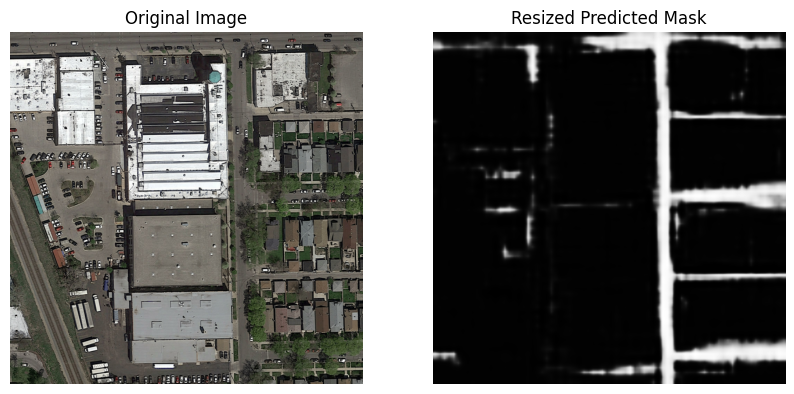

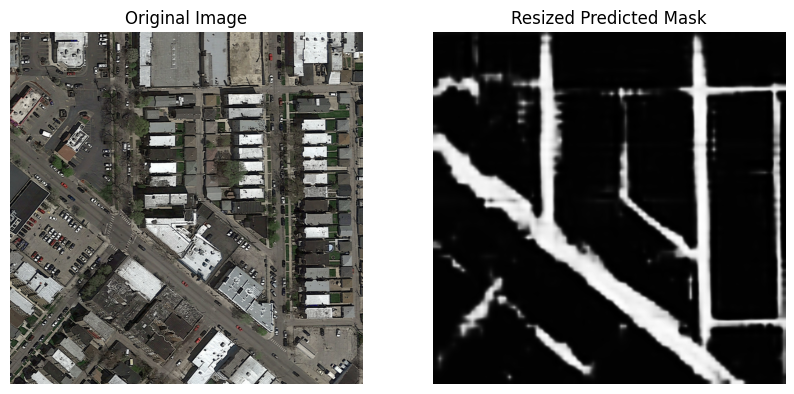

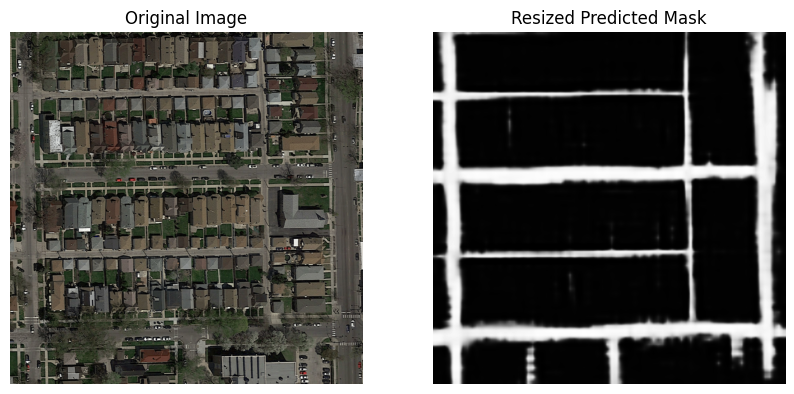

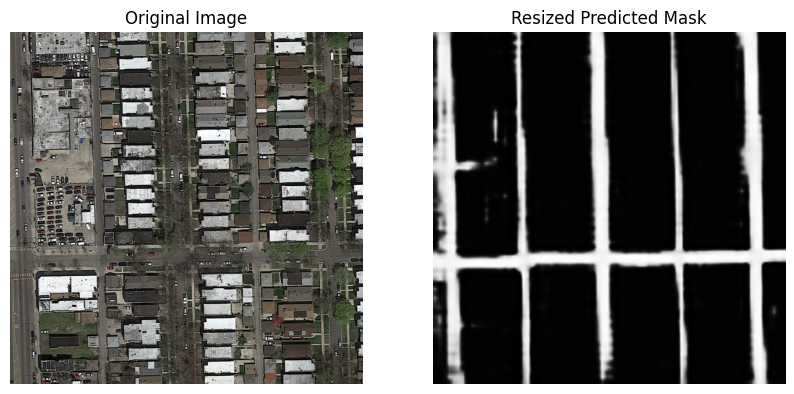

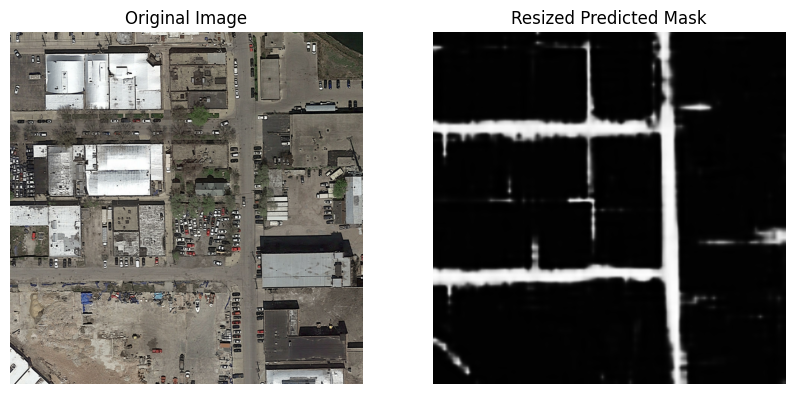

In [ ]:
import matplotlib.pyplot as plt

# Visualize some resized predictions
for i in range(min(5, len(predictions))):  # Show up to 5 predictions
    plt.figure(figsize=(10, 5))

    # Show original image
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(test_images[i].cpu().permute(1, 2, 0))  # Convert CHW to HWC for visualization
    plt.axis('off')

    # Show predicted mask
    plt.subplot(1, 2, 2)
    plt.title("Resized Predicted Mask")
    plt.imshow(predictions[i], cmap='gray')  # Display the resized mask
    plt.axis('off')

    plt.show()


In [ ]:
from google.colab import drive
import os
from PIL import Image
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in Drive to save the output masks
output_dir = '/content/drive/MyDrive/output_masks'
os.makedirs(output_dir, exist_ok=True)

# Save the output masks as images in the folder
for i, pred in enumerate(predictions):
    # Convert the mask to a PIL image
    mask_image = Image.fromarray((pred * 255).astype(np.uint8))  # Convert to 8-bit grayscale (0-255)

    # Define the output file path
    mask_file_path = os.path.join(output_dir, f"mask_{i+1}.png")

    # Save the image
    mask_image.save(mask_file_path)

print(f"Saved {len(predictions)} masks to {output_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved 50 masks to /content/drive/MyDrive/output_masks
